In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

!pip3 install autogluon.timeseries
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
# 設定 seaborn 主題，這會影響圖表的風格和顏色
sns.set_theme()  # Apply the default Seaborn theme
%matplotlib inline
# Libraries for statistical and scientific computing
import statsmodels.api as sm
from scipy import stats
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler

Defaulting to user installation because normal site-packages is not writeable


/Users/apple/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 使用pandas讀取CSV文件
df = pd.read_csv('https://raw.githubusercontent.com/xc90529/noninvasiv_visualization/main/DATA%20SET/noninvasive_data.csv')

# Calculating the Shock Index as PR / SYS
df['PR/SYS'] = df['PR'] / df['SYS']
# To display the top 5 rows
df.head(5)


#CO-心輸出量
#CI - 心輸出指數
#SV - 舒張容積
#SVI - 舒張容積指數
#SVV - 舒張容積變異度
#SVR - 舒張容積阻力
#SVRI - 舒張容積指數阻力
#PR - 脈搏率
#SYS - 收縮壓
#DIA - 舒張壓
#MAP - 平均動脈壓

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.000000,0.801724
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.333333,0.779661
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.666667,0.760331
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.000000,0.745763
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.333333,1.000000


In [40]:
# Calculating the Shock Index as PR / SYS
df['PR/SYS'] = df['PR'] / df['SYS']

# Displaying the first few rows of the dataframe to confirm the new variable
df.head()

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.000000,0.801724
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.333333,0.779661
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.666667,0.760331
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.000000,0.745763
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.333333,1.000000


In [41]:
# Remove the 'ID' column and the 'si1m' column from your DataFrame
columns_to_check = df.drop(columns=['ID', 'si1m', ])

# Use the duplicated method to find duplicate rows
duplicate_rows = df[df.duplicated(subset=columns_to_check, keep=False)]

# Print the content of duplicate rows
print("Duplicate rows:")
print(duplicate_rows)
# 要排除的列名
columns_to_exclude = ['ID', 'si1m']

# 选择除了要排除的列以外的其他列
columns_to_check = df.columns[~df.columns.isin(columns_to_exclude)]

# 使用 selected_columns 作为子集来检查重复行，保留第一个重复行
duplicate_rows_df = df[df.duplicated(subset=columns_to_check, keep='first')]

# 打印重复行的数量
print("重复行的数量：", duplicate_rows_df.shape[0])

# 打印重复行的内容
print("重复行：")
print(duplicate_rows_df)
# 重置索引
df.reset_index(drop=True, inplace=True)

# 在原始数据框 df 中删除重复行
df = df.drop(duplicate_rows_df.index)

# 现在 df 中已经不包含重复行
print(df)

Duplicate rows:
      si1m   CO        CI  SV        SVI  SVV     SVR         SVRI   PR  SYS  \
17619    N  3.1  1.962025  49  31.012658   18  1558.0   986.075949   64   97   
17620    N  3.1  1.962025  49  31.012658   18  1558.0   986.075949   64   97   
17621    Y  2.9  1.835443  46  29.113924   17  1643.0  1039.873418   63   94   
17622    N  2.9  1.835443  46  29.113924   17  1643.0  1039.873418   63   94   
17623    Y  2.8  1.772152  45  28.481013   18  1878.0  1188.607595   62  101   
...    ...  ...       ...  ..        ...  ...     ...          ...  ...  ...   
35911    N  3.1  2.300000  27  20.000000   16  2038.0  2790.000000  116  101   
35912    Y  3.1  2.200000  27  20.000000   16  2045.0  2800.000000  112  101   
35913    N  3.1  2.200000  27  20.000000   16  2045.0  2800.000000  112  101   
35914    Y  2.9  2.100000  29  21.000000   13  2150.0  2945.000000  102  101   
35915    N  2.9  2.100000  29  21.000000   13  2150.0  2945.000000  102  101   

       DIA  MAP    ID  

In [42]:
# 四舍五入 df 中的所有数值列到小数点后第五位
rounded_df = df.round(5)

rounded_df.head()

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
0,N,4.0,2.4,43,26.0,10,1673.0,2745.0,93,116,74,91,#_1,120.00000,0.80172
1,N,4.0,2.4,43,26.0,10,1683.0,2760.0,92,118,74,91,#_1,120.33333,0.77966
2,N,3.6,2.2,39,24.0,17,1978.0,3245.0,92,121,80,97,#_1,120.66667,0.76033
3,N,3.6,2.2,41,25.0,17,1868.0,3065.0,88,118,76,93,#_1,121.00000,0.74576
4,N,4.2,2.6,42,26.0,10,1335.0,2190.0,100,100,66,78,#_1,121.33333,1.00000


相關係數分析

In [43]:
# 將 'si1m' 欄的 'Y' 轉換為 1，'N' 轉換為 0
rounded_df['si1m'] = rounded_df['si1m'].map({'Y': 1, 'N': 0})

# 计算除 'ID' 'si1m' 列外的所有列的 Pearson 相关系数
correlation_matrix = rounded_df.drop(['ID', 'si1m'], axis=1).corr()

# 打印与 'PR/SYS' 相关的相关系数
print(correlation_matrix['PR/SYS'])


CO        0.075229
CI        0.088904
SV       -0.367625
SVI      -0.407779
SVV       0.234460
SVR      -0.258130
SVRI     -0.187680
PR        0.743472
SYS      -0.708988
DIA      -0.183142
MAP      -0.494982
time     -0.238417
PR/SYS    1.000000
Name: PR/SYS, dtype: float64


In [44]:
## 計算'si1m'和'PR/SYS'相關性
import scipy.stats

# 确保 si1m 是二元分类变量
point_biserial_corr = scipy.stats.pointbiserialr(rounded_df['si1m'], rounded_df['PR/SYS'])
print("Point Biserial Correlation between 'si1m' and 'PR/SYS':", point_biserial_corr.correlation)

##選擇PR,SYS,SVI,MAP,si1m來預測PR/SYS

Point Biserial Correlation between 'si1m' and 'PR/SYS': 0.6480595105599248


In [45]:
# 選擇病人 #_9 的數據
id9 = rounded_df[rounded_df['ID'] == '#_9']
id9

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
6590,0,3.6,2.3,46,29.0,19,1444.44444,2260.86957,78,91,57,69,#_9,120.00000,0.85714
6591,0,3.8,2.4,42,27.0,35,1452.63158,2300.00000,90,94,60,73,#_9,120.33333,0.95745
6592,0,4.3,2.8,48,31.0,22,1227.90698,1885.71429,89,88,59,70,#_9,120.66667,1.01136
6593,0,4.4,2.9,47,30.0,20,1236.36364,1875.86207,95,92,59,72,#_9,121.00000,1.03261
6594,0,4.2,2.7,44,28.0,22,1238.09524,1925.92593,96,89,56,69,#_9,121.33333,1.07865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8796,0,3.0,2.0,42,27.0,21,1840.00000,2760.00000,73,90,61,73,#_9,1393.00000,0.81111
8797,0,2.5,1.6,35,22.0,21,2016.00000,3150.00000,73,81,56,67,#_9,1393.33333,0.90123
8798,0,3.4,2.2,46,30.0,34,1694.11765,2618.18182,74,89,63,76,#_9,1394.66667,0.83146
8799,0,2.4,1.5,35,22.0,34,1766.66667,2826.66667,68,70,44,57,#_9,1395.00000,0.97143


移除異常值

In [46]:
# 参数化测试集占总数据的比例
test_ratio = 0.2

# 计算各数据集的大小
total_size = len(id9)
test_size = int(total_size * test_ratio)  # 计算测试集大小

# 剩余的为训练集大小
train_size = total_size - test_size

# 定义分割索引
test_start = total_size - test_size

# 分割DataFrame
train_df = id9.iloc[:test_start]
test_df = id9.iloc[test_start:]

# 检查分割结果
print(f"训练集大小：{len(train_df)}")
print(f"测试集大小：{len(test_df)}")


训练集大小：1769
测试集大小：442


In [47]:
train_df

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
6590,0,3.6,2.3,46,29.0,19,1444.44444,2260.86957,78,91,57,69,#_9,120.00000,0.85714
6591,0,3.8,2.4,42,27.0,35,1452.63158,2300.00000,90,94,60,73,#_9,120.33333,0.95745
6592,0,4.3,2.8,48,31.0,22,1227.90698,1885.71429,89,88,59,70,#_9,120.66667,1.01136
6593,0,4.4,2.9,47,30.0,20,1236.36364,1875.86207,95,92,59,72,#_9,121.00000,1.03261
6594,0,4.2,2.7,44,28.0,22,1238.09524,1925.92593,96,89,56,69,#_9,121.33333,1.07865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,0,4.0,2.6,37,24.0,0,1780.00000,2738.46154,109,118,76,93,#_9,1160.66667,0.92373
8355,0,5.8,3.7,53,34.0,0,1158.62069,1816.21622,110,110,72,88,#_9,1161.00000,1.00000
8356,0,4.0,2.6,34,22.0,17,1680.00000,2584.61538,119,110,75,88,#_9,1161.33333,1.08182
8357,0,5.1,3.3,49,31.0,17,1364.70588,2109.09091,104,109,75,91,#_9,1161.66667,0.95413


In [48]:
test_df

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
8359,0,4.1,2.6,38,25.0,24,1756.09756,2769.23077,106,120,77,94,#_9,1162.33333,0.88333
8360,0,4.0,2.6,36,23.0,24,1580.00000,2430.76923,110,103,68,83,#_9,1162.66667,1.06796
8361,0,5.1,3.3,45,29.0,21,1301.96078,2012.12121,115,108,71,87,#_9,1163.00000,1.06481
8362,0,4.4,2.8,41,26.0,22,1400.00000,2200.00000,107,107,66,81,#_9,1163.33333,1.00000
8363,0,4.6,2.9,44,28.0,24,1460.86957,2317.24138,104,113,72,88,#_9,1163.66667,0.92035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8796,0,3.0,2.0,42,27.0,21,1840.00000,2760.00000,73,90,61,73,#_9,1393.00000,0.81111
8797,0,2.5,1.6,35,22.0,21,2016.00000,3150.00000,73,81,56,67,#_9,1393.33333,0.90123
8798,0,3.4,2.2,46,30.0,34,1694.11765,2618.18182,74,89,63,76,#_9,1394.66667,0.83146
8799,0,2.4,1.5,35,22.0,34,1766.66667,2826.66667,68,70,44,57,#_9,1395.00000,0.97143


In [49]:
train_df
# 查看 'PR/SYS' 列的最大值和最小值
train_df_pr_sys_max = train_df['PR/SYS'].max()
train_df_pr_sys_min = train_df['PR/SYS'].min()

train_df_pr_sys_max, train_df_pr_sys_min

(1.44928, 0.30657)

In [50]:
test_df
# 查看 'PR/SYS' 列的最大值和最小值
test_pr_sys_max = test_df['PR/SYS'].max()
test_pr_sys_min = test_df['PR/SYS'].min()

test_pr_sys_max, test_pr_sys_min 

(2.10714, 0.36111)

In [51]:
# 定义异常值检测和移除函数，只处理数值列
def remove_outliers(df):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = ((df[numeric_cols] >= lower_bound) & (df[numeric_cols] <= upper_bound)).all(axis=1)
    return df[mask]

# 分别处理训练集和测试集的异常值
train_df_cleaned = remove_outliers(train_df)
test_df_cleaned = remove_outliers(test_df)
# 检查分割结果
print(f"训练集大小：{len(train_df_cleaned)}")
print(f"测试集大小：{len(test_df_cleaned)}")

训练集大小：1527
测试集大小：372


In [52]:
# 查找 'PR/SYS' 列的最大值
pr_sys_max = train_df_cleaned['PR/SYS'].max()

# 查找 'PR/SYS' 列的最小值
pr_sys_min = train_df_cleaned['PR/SYS'].min()

print(f"'PR/SYS' 最大值: {pr_sys_max}")
print(f"'PR/SYS' 最小值: {pr_sys_min}")


'PR/SYS' 最大值: 1.02174
'PR/SYS' 最小值: 0.54688


In [53]:
 # 查找 'PR/SYS' 列的最大值
pr_sys_max = test_df_cleaned['PR/SYS'].max()

# 查找 'PR/SYS' 列的最小值
pr_sys_min = test_df_cleaned['PR/SYS'].min()

print(f"'PR/SYS' 最大值: {pr_sys_max}")
print(f"'PR/SYS' 最小值: {pr_sys_min}")


'PR/SYS' 最大值: 1.11429
'PR/SYS' 最小值: 0.57143


In [54]:
# 假设 train_df, val_df, test_df 分别是已经处理异常值的训练集、未处理异常值的验证集和测试集
# 如果您已经移除了训练集中的异常值并保存在 filtered_train_df，确保这里使用正确的变量名

# 合并训练集、验证集和测试集
combined_df = pd.concat([train_df_cleaned, test_df_cleaned], axis=0)

# 检查合并后的数据集大小
print(f"合并后的数据集大小: {combined_df.shape}")

# 现在 combined_df 包含了整个数据集，您可以在这个数据集上进行缺失值的填充



合并后的数据集大小: (1899, 15)


In [55]:
combined_df

,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,time,PR/SYS
6590,0,3.6,2.3,46,29.0,19,1444.44444,2260.86957,78,91,57,69,#_9,120.00000,0.85714
6595,0,4.3,2.8,50,32.0,19,1265.11628,1942.85714,87,94,58,72,#_9,121.66667,0.92553
6597,0,4.6,3.0,54,35.0,23,1234.78261,1893.33333,84,95,61,75,#_9,122.33333,0.88421
6598,0,4.8,3.1,58,37.0,9,1200.00000,1858.06452,83,93,59,76,#_9,122.66667,0.89247
6599,0,4.4,2.8,47,30.0,15,1236.36364,1942.85714,94,92,59,72,#_9,123.00000,1.02174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,0,3.1,2.0,43,28.0,23,1987.09677,3080.00000,73,101,65,81,#_9,1391.33333,0.72277
8792,0,3.3,2.1,44,28.0,26,1890.90909,2971.42857,75,104,67,82,#_9,1391.66667,0.72115
8794,0,2.8,1.8,38,24.0,17,1942.85714,3022.22222,73,92,58,72,#_9,1392.33333,0.79348
8796,0,3.0,2.0,42,27.0,21,1840.00000,2760.00000,73,90,61,73,#_9,1393.00000,0.81111


填充id9 120~1395的缺失值，以0.33333為單位

In [56]:
import pandas as pd
import numpy as np

# Removing ID prefix and converting to integers for correct sorting
patient_time_ranges = combined_df.groupby('ID')['time'].agg(['min', 'max'])
patient_time_ranges['ID_numeric'] = patient_time_ranges.index.str.replace('#_', '').astype(int)
patient_time_ranges_sorted = patient_time_ranges.sort_values('ID_numeric')

# Create a mapping from ID to their min and max times
time_ranges = patient_time_ranges_sorted.to_dict('index')

# Function to create and fill the time range based on min and max times for a specific patient
def fill_time_for_id(group, id):
    if group['ID'].iloc[0] == id:
        min_time, max_time = time_ranges[id]['min'], time_ranges[id]['max']
        
        # Generate the full range of desired time values including fractional times
        full_time_range = np.arange(min_time, max_time + 0.00001, 1/3)
        full_time_range = np.round(full_time_range, 5)  # round to 5 decimal places

        # Creating a DataFrame for the complete time range
        full_df = pd.DataFrame(full_time_range, columns=['time'])

        # Merging this with the existing group data
        merged_group = pd.merge(full_df, group, on='time', how='left')

        # Forward fill to handle the missing data
        merged_group.ffill(inplace=True)
        
        # For any remaining missing values (if any)
        merged_group.bfill(inplace=True)
        
        return merged_group
    else:
        return group

# Applying the filling function only to the group for ID #_9
filled_data = pd.concat([fill_time_for_id(group, '#_9') for _, group in combined_df.groupby('ID')])
selected_features_df= filled_data[filled_data['ID'] == '#_9']

# Display a sample of the filled data for ID #_9
selected_features_df.head(20)


,time,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,PR/SYS
0,120.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
1,120.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
2,120.66667,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
3,121.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
4,121.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
5,121.66667,0.0,4.3,2.8,50.0,32.0,19.0,1265.11628,1942.85714,87.0,94.0,58.0,72.0,#_9,0.92553
6,122.00000,0.0,4.3,2.8,50.0,32.0,19.0,1265.11628,1942.85714,87.0,94.0,58.0,72.0,#_9,0.92553
7,122.33333,0.0,4.6,3.0,54.0,35.0,23.0,1234.78261,1893.33333,84.0,95.0,61.0,75.0,#_9,0.88421
8,122.66667,0.0,4.8,3.1,58.0,37.0,9.0,1200.00000,1858.06452,83.0,93.0,59.0,76.0,#_9,0.89247
9,123.00000,0.0,4.4,2.8,47.0,30.0,15.0,1236.36364,1942.85714,94.0,92.0,59.0,72.0,#_9,1.02174


In [57]:
selected_features_df

,time,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,PR/SYS
0,120.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
1,120.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
2,120.66667,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
3,121.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
4,121.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,1392.00000,0.0,3.3,2.1,44.0,28.0,26.0,1890.90909,2971.42857,75.0,104.0,67.0,82.0,#_9,0.72115
3817,1392.33333,0.0,2.8,1.8,38.0,24.0,17.0,1942.85714,3022.22222,73.0,92.0,58.0,72.0,#_9,0.79348
3818,1392.66667,0.0,2.8,1.8,38.0,24.0,17.0,1942.85714,3022.22222,73.0,92.0,58.0,72.0,#_9,0.79348
3819,1393.00000,0.0,3.0,2.0,42.0,27.0,21.0,1840.00000,2760.00000,73.0,90.0,61.0,73.0,#_9,0.81111


In [58]:
# 將時間填充好且特徵選取過後的數據，另存到桌面上 CSV 文件
selected_features_df .to_csv('~/Desktop/id9_Fin_0402.csv')


劃分訓練集 測試集

In [59]:
# 參數化測試集佔總資料的比例
test_ratio = 0.2 # 設定測試集佔總資料的20%

# 計算測試集的大小
total_size = len(selected_features_df)
test_size = int(total_size * test_ratio) # 計算測試集大小

# 分割索引
test_start = total_size - test_size

# 分割DataFrame為訓練集和測試集
train_df = selected_features_df.iloc[:test_start]
test_df = selected_features_df.iloc[test_start:]
extended_train_df = train_df.copy()

# 檢查分割結果
print(f"訓練集大小：{len(train_df)}")
print(f"測試集大小：{len(test_df)}")

訓練集大小：3057
測試集大小：764


In [60]:
test_df

,time,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,PR/SYS
3057,1139.00000,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3058,1139.33333,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3059,1139.66667,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3060,1140.00000,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3061,1140.33333,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,1392.00000,0.0,3.3,2.1,44.0,28.0,26.0,1890.90909,2971.42857,75.0,104.0,67.0,82.0,#_9,0.72115
3817,1392.33333,0.0,2.8,1.8,38.0,24.0,17.0,1942.85714,3022.22222,73.0,92.0,58.0,72.0,#_9,0.79348
3818,1392.66667,0.0,2.8,1.8,38.0,24.0,17.0,1942.85714,3022.22222,73.0,92.0,58.0,72.0,#_9,0.79348
3819,1393.00000,0.0,3.0,2.0,42.0,27.0,21.0,1840.00000,2760.00000,73.0,90.0,61.0,73.0,#_9,0.81111


In [61]:
train_df

,time,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,PR/SYS
0,120.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
1,120.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
2,120.66667,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
3,121.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
4,121.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,1137.33333,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3053,1137.66667,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3054,1138.00000,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3055,1138.33333,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909


In [62]:
extended_train_df

,time,si1m,CO,CI,SV,SVI,SVV,SVR,SVRI,PR,SYS,DIA,MAP,ID,PR/SYS
0,120.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
1,120.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
2,120.66667,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
3,121.00000,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
4,121.33333,0.0,3.6,2.3,46.0,29.0,19.0,1444.44444,2260.86957,78.0,91.0,57.0,69.0,#_9,0.85714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,1137.33333,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3053,1137.66667,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3054,1138.00000,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909
3055,1138.33333,0.0,5.0,3.2,45.0,29.0,11.0,1312.00000,2050.00000,111.0,110.0,67.0,86.0,#_9,1.00909


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from chronos import ChronosPipeline

# 加载模型
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # 根据实际情况选择设备
    torch_dtype=torch.float32,
)

# 定义要选择的特征列
features = ['PR/SYS']  # 添加你希望包含的特征

# 从train_df中选择这些特征
feature_data = train_df[features].to_numpy().astype('float32')

# 转换特征数据为PyTorch张量
context_tensor = torch.tensor(feature_data)

# 设置预测长度
prediction_length = 30

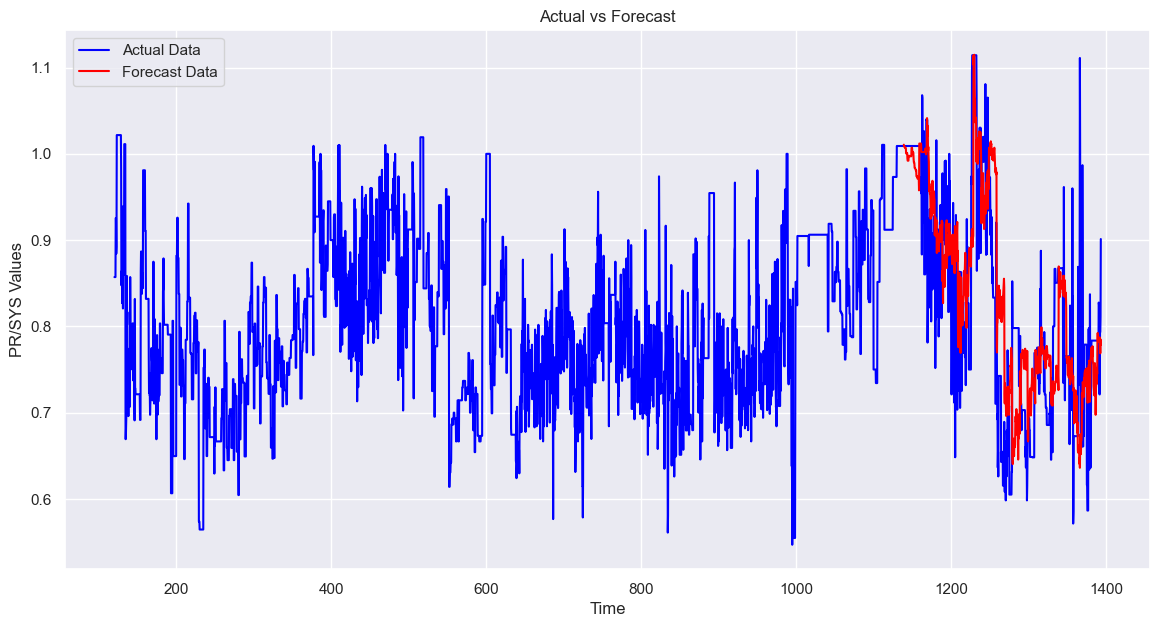

In [64]:
import pandas as pd

all_forecasts = pd.DataFrame()  # 存储所有预测结果


while not test_df.empty:
    # 更新上下文张量，包含了扩展后的训练集
    context_array = extended_train_df['PR/SYS'].to_numpy().astype('float32')
    context_tensor = torch.tensor(context_array).unsqueeze(0)  # 添加批次维度

    # 计算这轮预测的长度，不能超过测试集的剩余长度
    current_prediction_length = min(prediction_length, len(test_df))

    # 生成预测
    forecast = pipeline.predict(
        context=context_tensor,
        prediction_length=current_prediction_length,
        num_samples=10,
        temperature=1.0,
        top_k=50,
        top_p=1.0,
    )

    # 假设 forecast 的形状是 (1, num_samples, current_prediction_length)
    # 计算所有样本的平均预测值
    forecast_mean = forecast.mean(dim=1).squeeze().numpy()

      # 準備這輪預測的時間值
    last_time = extended_train_df['time'].iloc[-1]
    forecast_times = np.round(last_time + np.arange(1, current_prediction_length + 1) * 0.33333333333, 5)

    # 将这轮的平均预测值与其时间值结合
    forecast_df = pd.DataFrame(data=forecast_mean, index=forecast_times, columns=['PR/SYS'])
    all_forecasts = pd.concat([all_forecasts, forecast_df])

    # 将接下来的一段时间的实际数据从测试集移动到扩展的训练集中
    actual_data_to_add = test_df.iloc[:current_prediction_length]
    extended_train_df = pd.concat([extended_train_df, actual_data_to_add])
    test_df = test_df.iloc[current_prediction_length:]
# 获取实际数据的时间戳，确保使用0.33333的时间间隔
actual_data = selected_features_df['PR/SYS']
actual_times = selected_features_df['time']  # 假设时间列是 'time'

# 获取预测数据并将其与实际数据合并
forecast_data = all_forecasts['PR/SYS']
forecast_times = all_forecasts.index  # 假设 forecast_times 已经按照0.33333间隔设置

# 绘制实际数据和预测数据，确保时间间隔一致
plt.figure(figsize=(14, 7))
plt.plot(actual_times, actual_data, label='Actual Data', color='blue')
plt.plot(forecast_times, forecast_data, label='Forecast Data', color='red', linestyle='-')
plt.title('Actual vs Forecast')
plt.xlabel('Time')
plt.ylabel('PR/SYS Values')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
forecast_times

Index([    1139.0, 1139.33334, 1139.66667,     1140.0, 1140.33334, 1140.66667,
           1141.0, 1141.33334, 1141.66667,     1142.0,
       ...
       1390.33334, 1390.66667,     1391.0, 1391.33334, 1391.66667,     1392.0,
       1392.33334, 1392.66667,     1393.0, 1393.33334],
      dtype='float64', length=764)

In [66]:
forecast_df

,PR/SYS
1389.00000,0.784345
1389.33334,0.792401
1389.66667,0.782618
1390.00000,0.782618
1390.33334,0.782618
1390.66667,0.782618
1391.00000,0.783194
1391.33334,0.782618
1391.66667,0.782618
1392.00000,0.787222


In [67]:
all_forecasts

,PR/SYS
1139.00000,1.010600
1139.33334,1.008682
1139.66667,1.008682
1140.00000,1.008042
1140.33334,1.008042
...,...
1392.00000,0.787222
1392.33334,0.782618
1392.66667,0.768807
1393.00000,0.784920


In [68]:
actual_data 

0       0.85714
1       0.85714
2       0.85714
3       0.85714
4       0.85714
         ...   
3816    0.72115
3817    0.79348
3818    0.79348
3819    0.81111
3820    0.90123
Name: PR/SYS, Length: 3821, dtype: float64

In [69]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error between two arrays."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]))

def mae(y_true, y_pred):
    """Calculate Mean Absolute Error using sklearn."""
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    """Calculate Mean Squared Error using sklearn."""
    return mean_squared_error(y_true, y_pred)

# Assuming actual_data and forecast_data are pandas DataFrames
# 将预测数据与实际数据对齐
common_index = actual_data.index.intersection(forecast_data.index)
actual_data_aligned = actual_data.loc[common_index].values
forecast_data_aligned = forecast_data.loc[common_index].values

# 计算MAPE, MAE, 和 MSE
MAPE = mape(actual_data_aligned, forecast_data_aligned)
MAE = mae(actual_data_aligned, forecast_data_aligned)
MSE = mse(actual_data_aligned, forecast_data_aligned)

print(f"MAPE: {MAPE}")
print(f"MAE: {MAE}")
print(f"MSE: {MSE}")


MAPE: 0.12013115699534409
MAE: 0.09705051981967103
MSE: 0.014486079833233056


In [70]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error between two arrays."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

def mae(y_true, y_pred):
    """Calculate Mean Absolute Error using sklearn."""
    return mean_absolute_error(y_true, y_pred)* 100

def mse(y_true, y_pred):
    """Calculate Mean Squared Error using sklearn."""
    return mean_squared_error(y_true, y_pred)* 100

# Assuming actual_data and forecast_data are pandas DataFrames
# 将预测数据与实际数据对齐
common_index = actual_data.index.intersection(forecast_data.index)
actual_data_aligned = actual_data.loc[common_index].values
forecast_data_aligned = forecast_data.loc[common_index].values

# 计算MAPE, MAE, 和 MSE
MAPE = mape(actual_data_aligned, forecast_data_aligned)
MAE = mae(actual_data_aligned, forecast_data_aligned)
MSE = mse(actual_data_aligned, forecast_data_aligned)

print(f"MAPE: {MAPE}%")
print(f"MAE: {MAE}%")
print(f"MSE: {MSE}%")


MAPE: 12.013115699534408%
MAE: 9.705051981967102%
MSE: 1.4486079833233056%


In [71]:
forecast_data

1139.00000    1.010600
1139.33334    1.008682
1139.66667    1.008682
1140.00000    1.008042
1140.33334    1.008042
                ...   
1392.00000    0.787222
1392.33334    0.782618
1392.66667    0.768807
1393.00000    0.784920
1393.33334    0.778590
Name: PR/SYS, Length: 764, dtype: float32

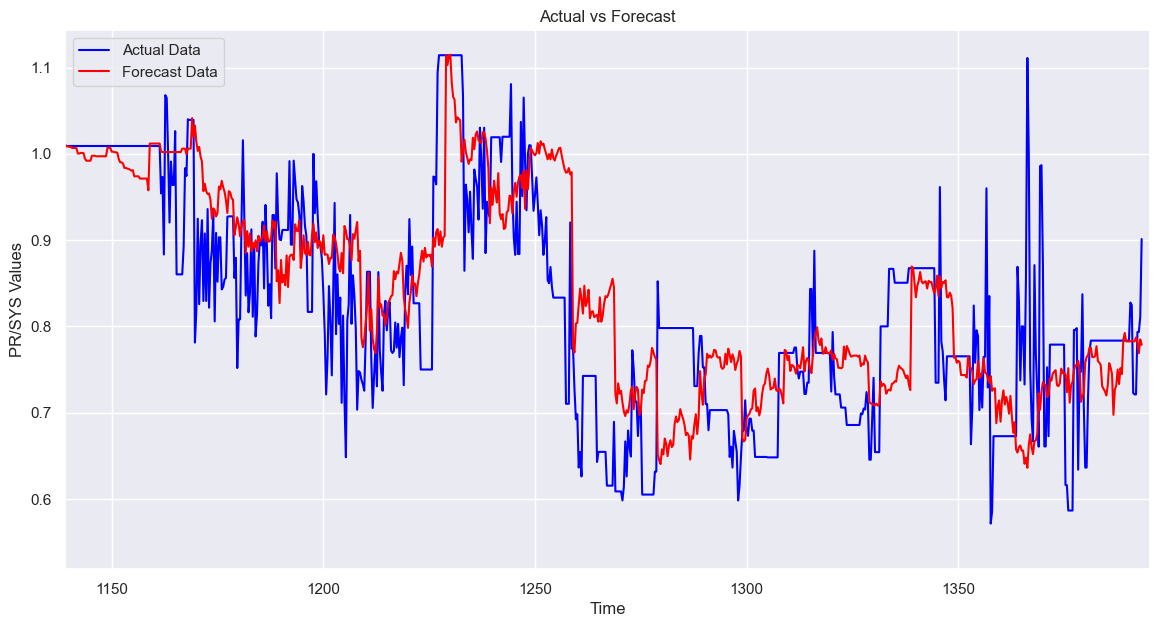

In [72]:
# 绘制实际数据和预测数据，确保时间间隔一致
plt.figure(figsize=(14, 7))
plt.plot(actual_times, actual_data, label='Actual Data', color='blue')
plt.plot(forecast_times, forecast_data, label='Forecast Data', color='red', linestyle='-')
plt.title('Actual vs Forecast')
plt.xlabel('Time')
plt.ylabel('PR/SYS Values')
plt.legend()
plt.grid(True)

# 设置横坐标范围，放大显示指定范围的数据
plt.xlim(1139.0000, 1395.33333)

plt.show()